In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
IS_KAGGLE = False

IS_SCALLER_ON = True

In [3]:
if IS_KAGGLE:
    #Kaggle
    train_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv")
    test_df = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv")
else:
    train_df = pd.read_csv("datasets/ventilation/train.csv")
    test_df = pd.read_csv("datasets/ventilation/test.csv")

R distribution and C
Lung attribute indicating how restricted the airway is

C - lung attribute indicating how compliant the lung is (in mL/cmH2O).
Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.


                         Normal lungs	ARDS
    Compliance (ml/cmH2O)	50–60	35–45
    Resistance (cmH2O/(l/s))	10–15	10–15
    Expiratory time constant (s)	0.5–0.7	0.4–0.6



### Sort Training and Test set by breath id and id

In [4]:
sorted_train_df = train_df.sort_values(by=["id","breath_id"])
sorted_test_df = test_df.sort_values(by=["id","breath_id"])

## Based on https://www.hamilton-medical.com/en_US/News/Newsletter-articles/Article~2018-04-25~Bedside-tip%3A-How-to-use-the-expiratory-time-constant~a90bbb8e-6848-4854-ad6f-2f8e86e16f81~.html

RC is decaying exponentially

In [5]:
R_train = sorted_train_df.pop("R")
C_train = sorted_train_df.pop("C")
time_step_train = sorted_train_df.pop("time_step")

R_test = sorted_test_df.pop("R")
C_test = sorted_test_df.pop("C")
time_step_test = sorted_test_df.pop("time_step")

In [6]:
R_C_train = (R_train*C_train)
R_C_test= (R_test*C_test)

In [7]:
R_C_exp_decay_train = (1/R_C_train)*np.exp(-(time_step_train-3))
R_C_exp_decay_test = (1/R_C_test)*np.exp(-(time_step_test-3))

In [8]:
sorted_train_df['R_C_exp'] = R_C_exp_decay_train
sorted_test_df['R_C_exp'] = R_C_exp_decay_test

<AxesSubplot: >

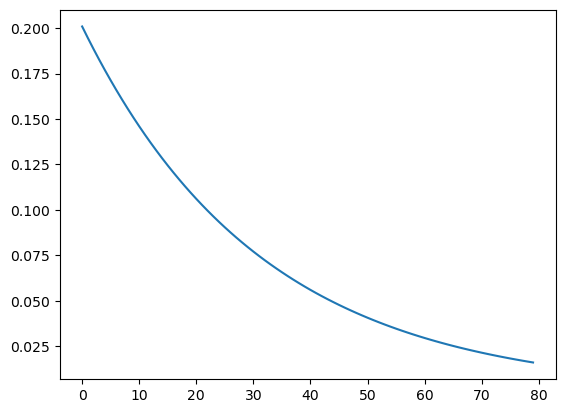

In [9]:
sorted_test_df.query("breath_id==0")["R_C_exp"].plot()

<AxesSubplot: >

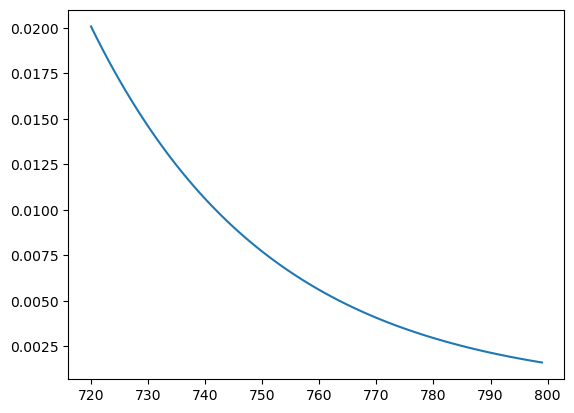

In [10]:
sorted_train_df.query("breath_id==12")["R_C_exp"].plot()

In [11]:
## u_OUT

u_out_train = sorted_train_df.pop('u_out')

u_out_test = sorted_test_df.pop('u_out')

## Express u_in as a vector

In [12]:
u_in_train = sorted_train_df.pop('u_in')
u_in_test = sorted_test_df.pop('u_in')

### Train

In [13]:
#over 3 time steps

sin_u_in_train = u_in_train*np.sin(2*np.pi*(u_in_train*time_step_train/3))

cos_u_in_train = u_in_train*np.cos(2*np.pi*(u_in_train*time_step_train/3))

sorted_train_df['sin_u_in'] = sin_u_in_train*np.cos(u_in_train)

sorted_train_df['cos_u_in'] = cos_u_in_train*np.cos(u_in_train)

### Test

In [14]:
sin_u_in_test = u_in_test*np.sin(2*np.pi*(u_in_test*time_step_test/3))

cos_u_in_test = u_in_test*np.cos(2*np.pi*(u_in_test*time_step_test/3))

sorted_test_df['sin_u_in'] = sin_u_in_test*np.cos(u_in_test)

sorted_test_df['cos_u_in'] = cos_u_in_test*np.cos(u_in_test)

<AxesSubplot: >

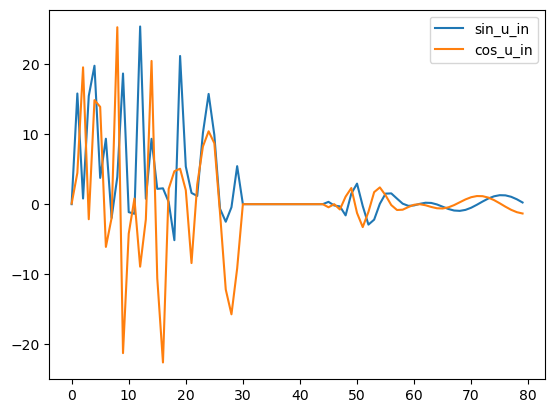

In [15]:
sorted_train_df.query("breath_id==1")[['sin_u_in', 'cos_u_in']].plot()

<AxesSubplot: >

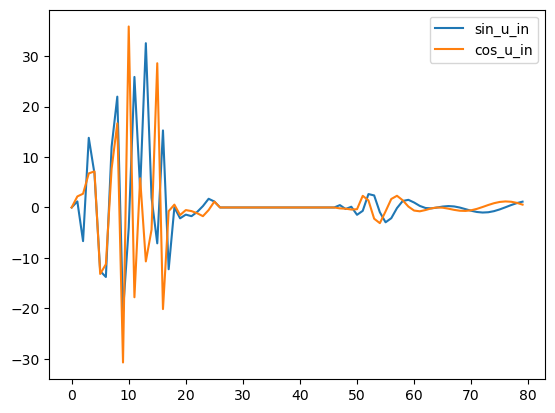

In [16]:
sorted_test_df.query("breath_id==0")[['sin_u_in', 'cos_u_in']].plot()

### time steps

### Train

In [17]:
sin_time_step_train = np.sin(2*np.pi*(time_step_train/3))

cos_time_step_train = np.cos(2*np.pi*(time_step_train/3))

sorted_train_df['sin_time_step'] = sin_time_step_train

sorted_train_df['cos_time_step'] = cos_time_step_train

### Test

In [18]:
#time_step

sin_time_step_test = np.sin(2*np.pi*(time_step_test/3))

cos_time_step_test = np.cos(2*np.pi*(time_step_test/3))

sorted_test_df['sin_time_step'] = sin_time_step_test

sorted_test_df['cos_time_step'] = cos_time_step_test

<AxesSubplot: >

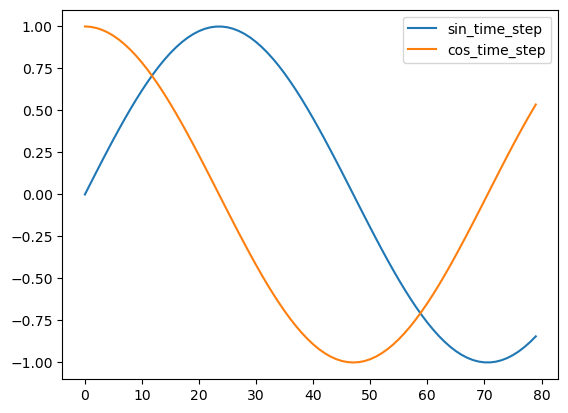

In [19]:
sorted_test_df.query("breath_id==0")[['sin_time_step', 'cos_time_step']].plot()

<AxesSubplot: >

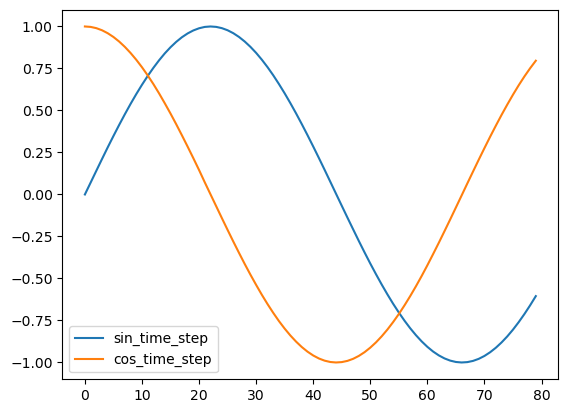

In [20]:
sorted_train_df.query("breath_id==1")[['sin_time_step', 'cos_time_step']].plot()

In [21]:
target = ['pressure']

features = ['R_C_exp', 'sin_u_in', 'cos_u_in', 'sin_time_step', 'cos_time_step']
# features = ['R_C_exp', 'sin_u_in', 'cos_u_in', 'u_out', 'sin_time_step', 'cos_time_step']
# features = ['R_C_exp', 'u_in', 'sin_time_step', 'u_out', 'cos_time_step']
# features = ['R_C_exp', 'u_in', 'sin_time_step', 'cos_time_step']

Each secuence has 80 points or timesteps

Dataset has 1 row per timestep 

the first 80 rows belong to the first series. My window lenght is 80 and the stride is 80 with 4 features.

## Test and Train datasets

In [22]:
X_train = sorted_train_df[features].to_numpy()
y_train = sorted_train_df[target].to_numpy()
X_test = sorted_test_df[features].to_numpy()

## Scale atributes

In [23]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

### Inspect one breath secuence after scaling atributes

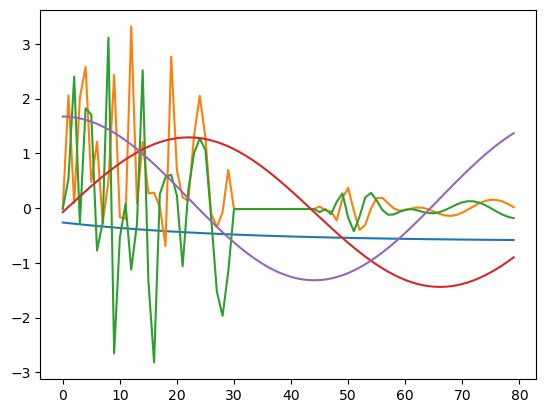

In [24]:
plt.plot(X_train[:80])

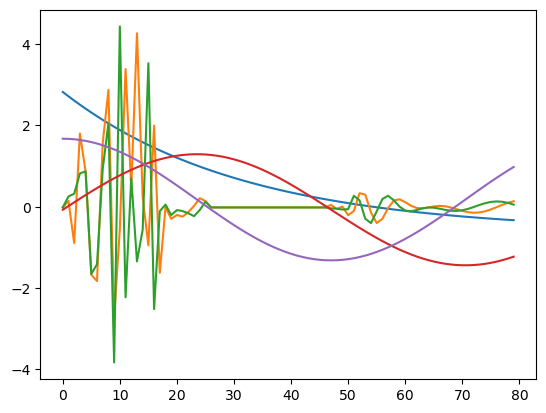

In [25]:
plt.plot(X_test[:80])

## Models

In [26]:
feature_lenght = len(features)

In [27]:
def build_windows(X):
    size=80
    shift=80
    stride=1
    drop_remainder=True
    
    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(size, shift, stride, drop_remainder)
    dataset = dataset.flat_map(lambda window: window.batch(size))
    dataset = dataset.map(lambda window: (window[:, :feature_lenght], window[:, feature_lenght:]))
    dataset = dataset.batch(2048).shuffle(32).prefetch(256)
    return dataset

def build_windows_predict(X):
    size=80
    shift=80
    stride=1
    drop_remainder=True

    dataset = tf.data.Dataset.from_tensor_slices(X)
    dataset = dataset.window(size, shift, stride, drop_remainder)
    dataset = dataset.flat_map(lambda window: window.batch(size))
    dataset = dataset.batch(512).prefetch(32)

    return dataset

In [28]:
test_dataset = build_windows_predict(X_test)
dataset_train = build_windows(np.concatenate([X_train, y_train], axis=1))

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-01-24 19:22:42.925120: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-24 19:22:42.925252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
#Base 1DCONV model
X_input = tf.keras.layers.Input(shape=(80, feature_lenght))

X = tf.keras.layers.Conv1D(16, 3, 1, padding='same', activation='relu')(X_input)
X = tf.keras.layers.Conv1D(16, 3, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(16, 3, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(16, 3, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Conv1D(32, 5, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(32, 5, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(32, 3, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(32, 3, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Conv1D(64, 7, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(64, 7, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(64, 7, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(64, 7, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Conv1D(128, 9, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(128, 9, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(128, 9, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(128, 9, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)
X = tf.keras.layers.Conv1D(256, 12, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(256, 12, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(256, 12, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.Conv1D(256, 12, 1, padding='same', activation='relu')(X)
X = tf.keras.layers.MaxPool1D(2)(X)

X = tf.keras.layers.Flatten()(X)

X = tf.keras.layers.Dense(4096, activation='swish')(X)
X = tf.keras.layers.Dropout(0.4)(X)
X = tf.keras.layers.Dense(4096, activation='swish')(X)
X = tf.keras.layers.Dropout(0.4)(X)

X_output = tf.keras.layers.Dense(80, activation='swish')(X)

lstm_model = tf.keras.Model(inputs=X_input, outputs=X_output)

In [30]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer="Adam",
            metrics=[tf.keras.metrics.MeanSquaredError()])

In [31]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 5)]           0         
                                                                 
 conv1d (Conv1D)             (None, 80, 16)            256       
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 16)            784       
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 16)            784       
                                                                 
 conv1d_3 (Conv1D)           (None, 80, 16)            784       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 16)           0         
 )                                                               
                                                             

In [32]:
lstm_model.fit(dataset_train, epochs=50, shuffle=True, use_multiprocessing=True)

Epoch 1/50


2023-01-24 19:22:45.389323: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-24 19:22:45.389597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 31s 466ms/step - loss: 763.6437 - mean_squared_error: 763.6437
Epoch 2/50
37/37 [==============================] - 24s 394ms/step - loss: 29.9220 - mean_squared_error: 29.9220
Epoch 3/50


2023-01-24 19:23:50.547782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 29 of 32
2023-01-24 19:23:51.601724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 25s 390ms/step - loss: 29.3373 - mean_squared_error: 29.3373
Epoch 4/50


2023-01-24 19:24:16.087847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 32
2023-01-24 19:24:16.723547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 26s 409ms/step - loss: 28.3535 - mean_squared_error: 28.3535
Epoch 5/50


2023-01-24 19:24:42.041518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 32
2023-01-24 19:24:42.758315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 25s 390ms/step - loss: 22.1763 - mean_squared_error: 22.1763
Epoch 6/50


2023-01-24 19:25:07.211164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 31 of 32
2023-01-24 19:25:07.530353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 24s 377ms/step - loss: 18.5617 - mean_squared_error: 18.5617
Epoch 7/50


2023-01-24 19:25:31.503708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 26 of 32
2023-01-24 19:25:33.604350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 30s 481ms/step - loss: 16.9126 - mean_squared_error: 16.9126
Epoch 8/50


2023-01-24 19:26:01.258251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 31 of 32
2023-01-24 19:26:01.610593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 25s 410ms/step - loss: 15.5158 - mean_squared_error: 15.5158
Epoch 9/50
37/37 [==============================] - 23s 353ms/step - loss: 14.2150 - mean_squared_error: 14.2150
Epoch 10/50


2023-01-24 19:26:50.021643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 32
2023-01-24 19:26:50.687094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 24s 365ms/step - loss: 13.1729 - mean_squared_error: 13.1729
Epoch 11/50
37/37 [==============================] - 23s 355ms/step - loss: 12.0014 - mean_squared_error: 12.0014
Epoch 12/50
37/37 [==============================] - 24s 359ms/step - loss: 11.5612 - mean_squared_error: 11.5612
Epoch 13/50
37/37 [==============================] - 22s 340ms/step - loss: 12.0548 - mean_squared_error: 12.0548
Epoch 14/50
37/37 [==============================] - 25s 417ms/step - loss: 10.6074 - mean_squared_error: 10.6074
Epoch 15/50
37/37 [==============================] - 24s 374ms/step - loss: 10.3445 - mean_squared_error: 10.3445
Epoch 16/50


2023-01-24 19:29:12.183684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 32
2023-01-24 19:29:12.799554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 26s 414ms/step - loss: 9.9139 - mean_squared_error: 9.9139
Epoch 17/50


2023-01-24 19:29:38.239440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 30 of 32
2023-01-24 19:29:38.919599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 26s 400ms/step - loss: 9.5063 - mean_squared_error: 9.5063
Epoch 18/50
37/37 [==============================] - 24s 379ms/step - loss: 8.9184 - mean_squared_error: 8.9184
Epoch 19/50
37/37 [==============================] - 25s 401ms/step - loss: 8.2931 - mean_squared_error: 8.2931
Epoch 20/50


2023-01-24 19:30:52.433710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 28 of 32
2023-01-24 19:30:53.801229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 29s 472ms/step - loss: 7.9531 - mean_squared_error: 7.9531
Epoch 21/50


2023-01-24 19:31:21.473945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 29 of 32
2023-01-24 19:31:22.409316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 28s 441ms/step - loss: 7.6163 - mean_squared_error: 7.6163
Epoch 22/50
37/37 [==============================] - 23s 360ms/step - loss: 7.1213 - mean_squared_error: 7.1213
Epoch 23/50
37/37 [==============================] - 27s 458ms/step - loss: 7.1202 - mean_squared_error: 7.1202
Epoch 24/50


2023-01-24 19:32:38.782011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 29 of 32
2023-01-24 19:32:39.806356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 25s 388ms/step - loss: 6.8762 - mean_squared_error: 6.8762
Epoch 25/50
37/37 [==============================] - 26s 442ms/step - loss: 6.6781 - mean_squared_error: 6.6781
Epoch 26/50
37/37 [==============================] - 27s 463ms/step - loss: 6.5183 - mean_squared_error: 6.5183
Epoch 27/50
37/37 [==============================] - 26s 423ms/step - loss: 6.3427 - mean_squared_error: 6.3427
Epoch 28/50
37/37 [==============================] - 28s 489ms/step - loss: 6.2220 - mean_squared_error: 6.2220
Epoch 29/50


2023-01-24 19:34:51.178586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 29 of 32
2023-01-24 19:34:52.235270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


37/37 [==============================] - 25s 365ms/step - loss: 6.3196 - mean_squared_error: 6.3196
Epoch 30/50
37/37 [==============================] - 21s 319ms/step - loss: 5.9814 - mean_squared_error: 5.9814
Epoch 31/50
37/37 [==============================] - 22s 334ms/step - loss: 5.8419 - mean_squared_error: 5.8419
Epoch 32/50
37/37 [==============================] - 21s 314ms/step - loss: 5.9593 - mean_squared_error: 5.9593
Epoch 33/50
37/37 [==============================] - 22s 352ms/step - loss: 5.5792 - mean_squared_error: 5.5792
Epoch 34/50
37/37 [==============================] - 21s 314ms/step - loss: 5.4710 - mean_squared_error: 5.4710
Epoch 35/50
37/37 [==============================] - 21s 316ms/step - loss: 5.3316 - mean_squared_error: 5.3316
Epoch 36/50
37/37 [==============================] - 22s 333ms/step - loss: 5.2690 - mean_squared_error: 5.2690
Epoch 37/50
37/37 [==============================] - 21s 317ms/step - loss: 5.2520 - mean_squared_error: 5.2520
Epoc

In [33]:
predictions = lstm_model.predict(test_dataset, verbose=1)

2023-01-24 19:43:29.862595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 7s 67ms/step


In [34]:
predictions_df = pd.DataFrame(zip(test_df.sort_values(['id', 'breath_id', 'time_step'],ascending=True).id.to_numpy(),
                                                        predictions.flatten()),
                                                        columns=['id', 'pressure']
                             )

In [35]:
predictions_df.to_csv("submission.csv", index=False)